# Exam Session 16 July 2024

Design a deep neural network able to output a segmented mask from a given
input image.

### Requirements

To run the code, it may be needed to install the following packages.

In [ ]:
!pip install scikeras[tensorflow]

In [ ]:
!pip install keras_tuner

In [ ]:
!pip install pydot

In [ ]:
!pip install visualkeras

In [ ]:
import urllib.request
import zipfile

import pickle as pk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model

import pydot
from IPython.display import Image
import visualkeras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier

from keras_tuner import HyperParameters, RandomSearch

First of all, I'll download the zip archive and extract it, to make it readable.

In [ ]:
zip_url = "https://github.com/ashley-andrea/DL-exam/raw/main/input_data.zip"
zip_path, _ = urllib.request.urlretrieve(zip_url)
target_folder = "temp"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

In [ ]:
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

The first operation I'm going to perform is actually an a posteriori choice, due to issues with computationl complexity. I will reduce the dataset to half of the original dimension, in order to make it easier to train the model, especially during hyperparameter tuning.

In [ ]:
def reduce_dataset(images, masks, fraction=0.5):
    num_samples = images.shape[0]
    num_selected = int(num_samples * fraction)

    # Randomly select indices
    selected_indices = np.random.choice(num_samples, num_selected, replace=False)

    # Select images and masks based on the selected indices
    reduced_images = images[selected_indices]
    reduced_masks = masks[selected_indices]

    return reduced_images, reduced_masks

In [ ]:
reduced_imgs, reduced_masks = reduce_dataset(imgs, masks, fraction=0.5)

print("Reduced images shape:", reduced_imgs.shape)
print("Reduced masks shape:", reduced_masks.shape)

imgs = reduced_imgs
masks = reduced_masks

Reduced images shape: (652, 256, 256, 3)
Reduced masks shape: (652, 256, 256, 1)


## 1. MODEL

The architecture that I'm going to implement for this task takes after U-Net, a Fully Convolutional Network suitable for image segmentation.

It affords shift-invariance to a certain degree and employs skip-connections, which help merge features from different resolution levels, addressing the challenge of information loss during down-sampling, while enabling gradients to flow more directly, mitigating issues related to vanishing or exploding grandients.

## 2. INPUT

The provided input data contains images and their masks. We can easily display a few examples to clearly grasp what we are working with.   


In [ ]:
print(len(imgs) == len(masks))
len(imgs)

True


652

The previous lines were just a sanity check to ensure the number of images and masks match. Now, I'll create a simple 3x2 grid to show the first 3 images and associated masks.

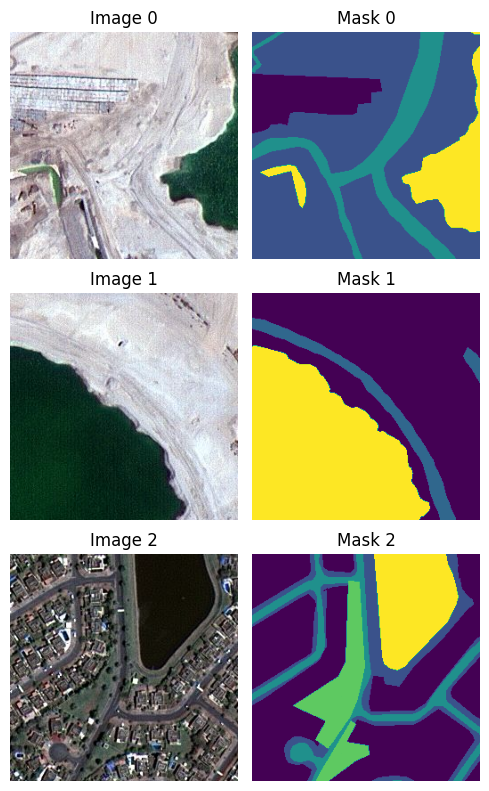

In [ ]:
num_samples = 3

plt.figure(figsize=(5, 8))

for i in range(num_samples):
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(imgs[i])
    plt.title(f"Image {i}")
    plt.axis("off")

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(masks[i])
    plt.title(f"Mask {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

What we will be working on is just the input images, as ground truth masks will be relevant later on in order to compare the model's predictions to our desired outputs.

First, let's define some useful parameters, that is, the number of possible classes we want to predict and the size of samples we would like to process in each training step.

In [ ]:
num_classes = 6
batch_size = 16

Now, let's start with preprocessing. The first thing I'm going to do is rescaling pixel values to a more manageable range, that is, from [0, 255] to [0, 1]. This operation, which can be easily performed by dividing by 255, ensures a faster and smoother convergence during training.

In [ ]:
imgs = imgs/255

Thus, we can procede to split our data into train and test sets, so that we will be able to later asses our model's performance on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imgs, masks, test_size=0.2, random_state=42)

In [ ]:
input_shape = imgs[0].shape
input_shape

(256, 256, 3)

After the preprocessing steps, the input of the model is still a 3D tensor, with shape 256x256x3. Hence, the **input layer** of our model will be defined as follows.

In [ ]:
input_layer = Input(shape=input_shape)

## 3. OUTPUT

The output layer of our model will be a convolutional layer employing a 1x1 kernel and a softmax activation function to predict which among the 6 possible classes each pixel belongs to. The 1x1 convolution allows for mixing features across different channels, while keeping the spatial resolution intact. It ensures that each pixel gets a set of class scores, one for each class, which are then converted to probabilities through the softmax activation. As a result, we will obtain a tensor with dimensions 256x256x6 as output segmentation map.

In [ ]:
output_layer = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')

## 4. LOSS

Since loss is computed pixel-wise and labels are integers from 0 to 5, we will use **sparse categorical cross-entropy** as loss function.

In [ ]:
loss_function = 'sparse_categorical_crossentropy'

Now I'll create a function to display images along with their ground truth masks and predicted masks.

To make the comparison between desired and predicted outputs more visually straightforward, I'll represent both the ground truth masks and the predicted masks as split into 6 channels, one for each class.

This operation is performed by creating, for each class *i*, a binary mask, where pixels belonging to class *i* are set to 1 and all other pixels are set to 0.

In [ ]:
def plot_example(image, mask, pred=None):
    plt.figure(figsize=(25, 10))
    ncols = num_classes
    nrows = 2 if pred is None else 3

    plt.subplot(nrows, ncols, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    for i in range(num_classes):
        mask_channel = (mask == i).astype(int)
        plt.subplot(nrows, ncols, i+num_classes+1)
        plt.imshow(mask_channel)
        plt.title(f"Mask, class {i}")
        plt.axis("off")

    if pred is not None:
        for i in range(num_classes):
            pred_channel = (pred == i).astype(int)
            plt.subplot(nrows, ncols, i+num_classes*2+1)
            plt.imshow(pred_channel)
            plt.title(f"Prediction, class {i}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

Again, we can just check out a few examples to see how the function works. Since we have yet to build the model and make predictions, only input images and ground truth masks, separated into classes, will be displayed.

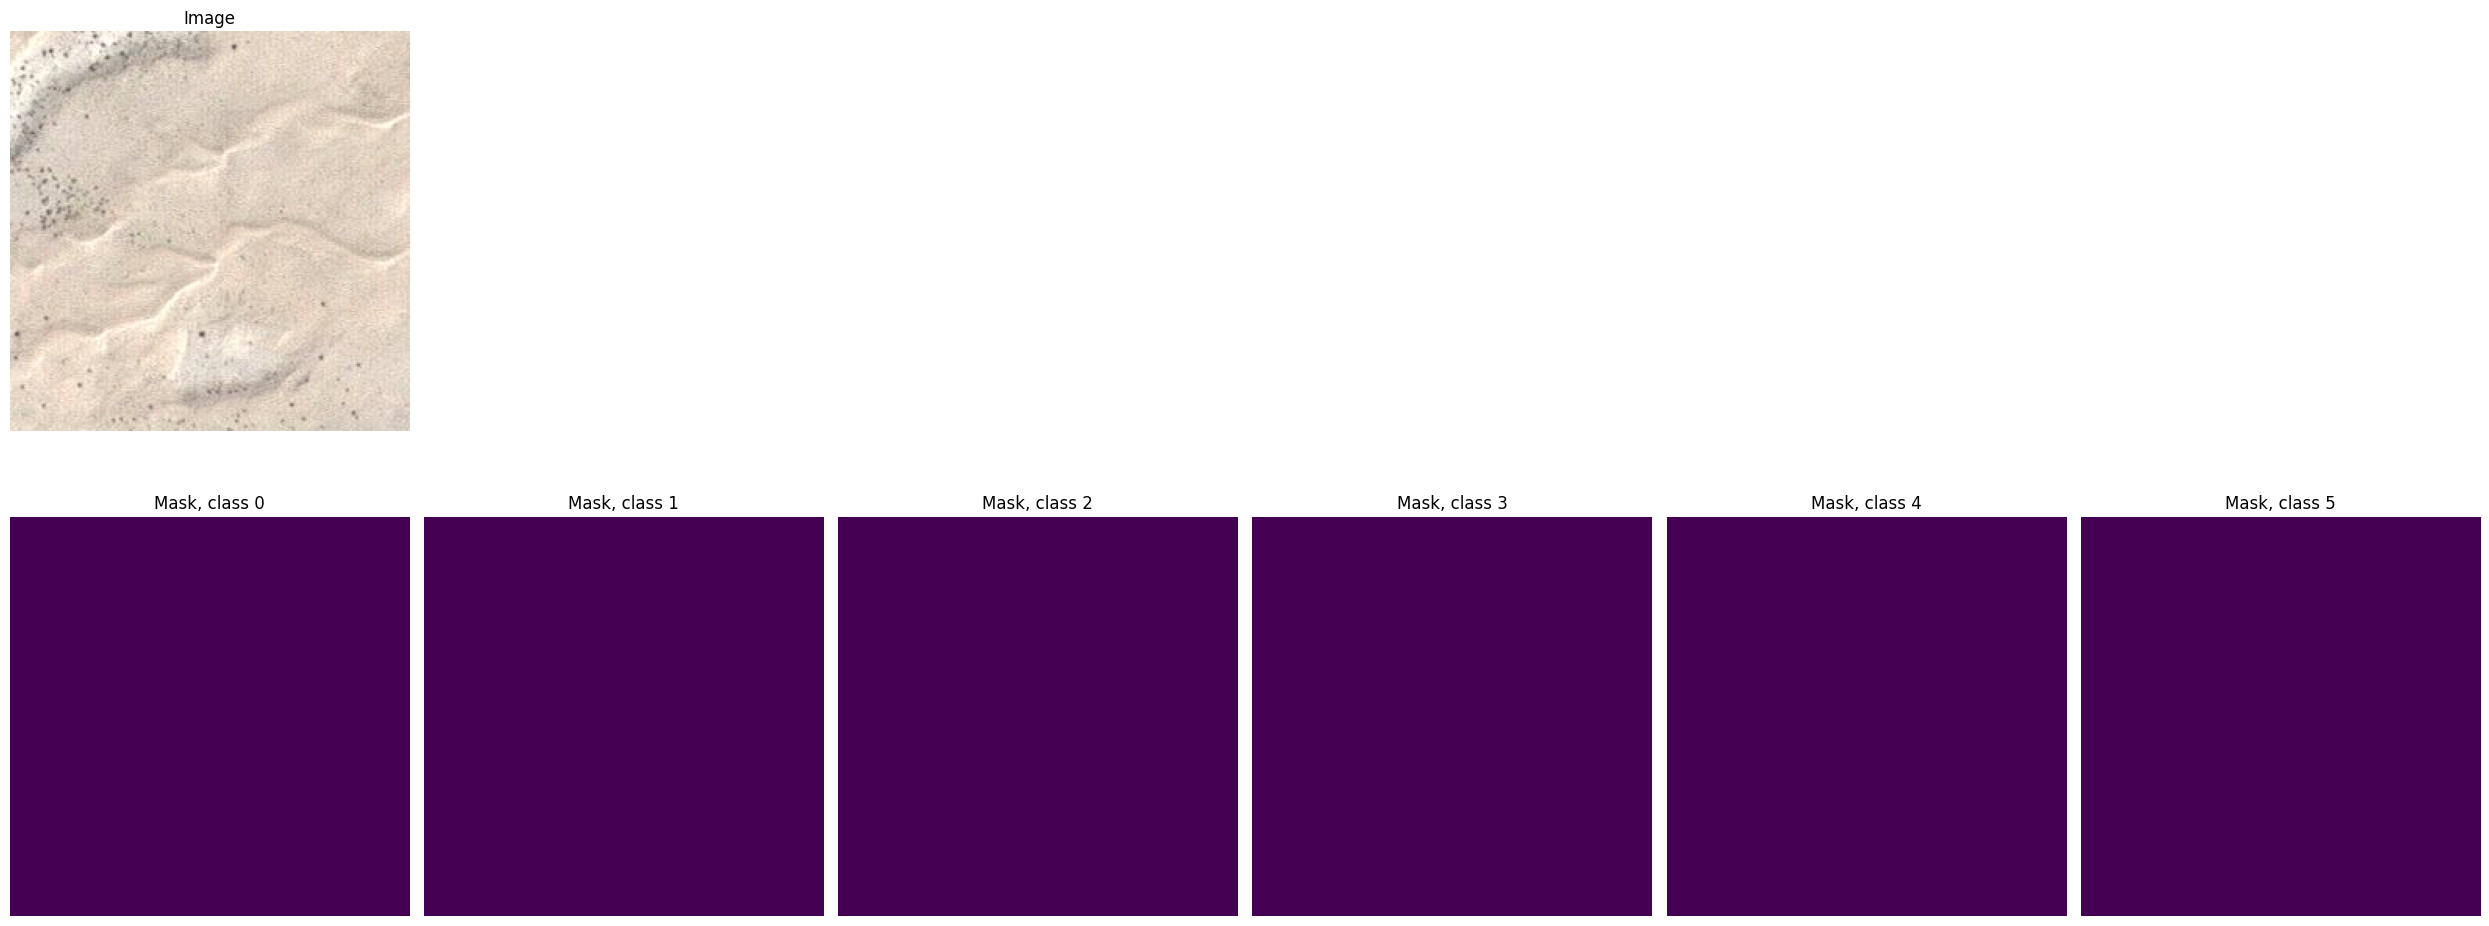

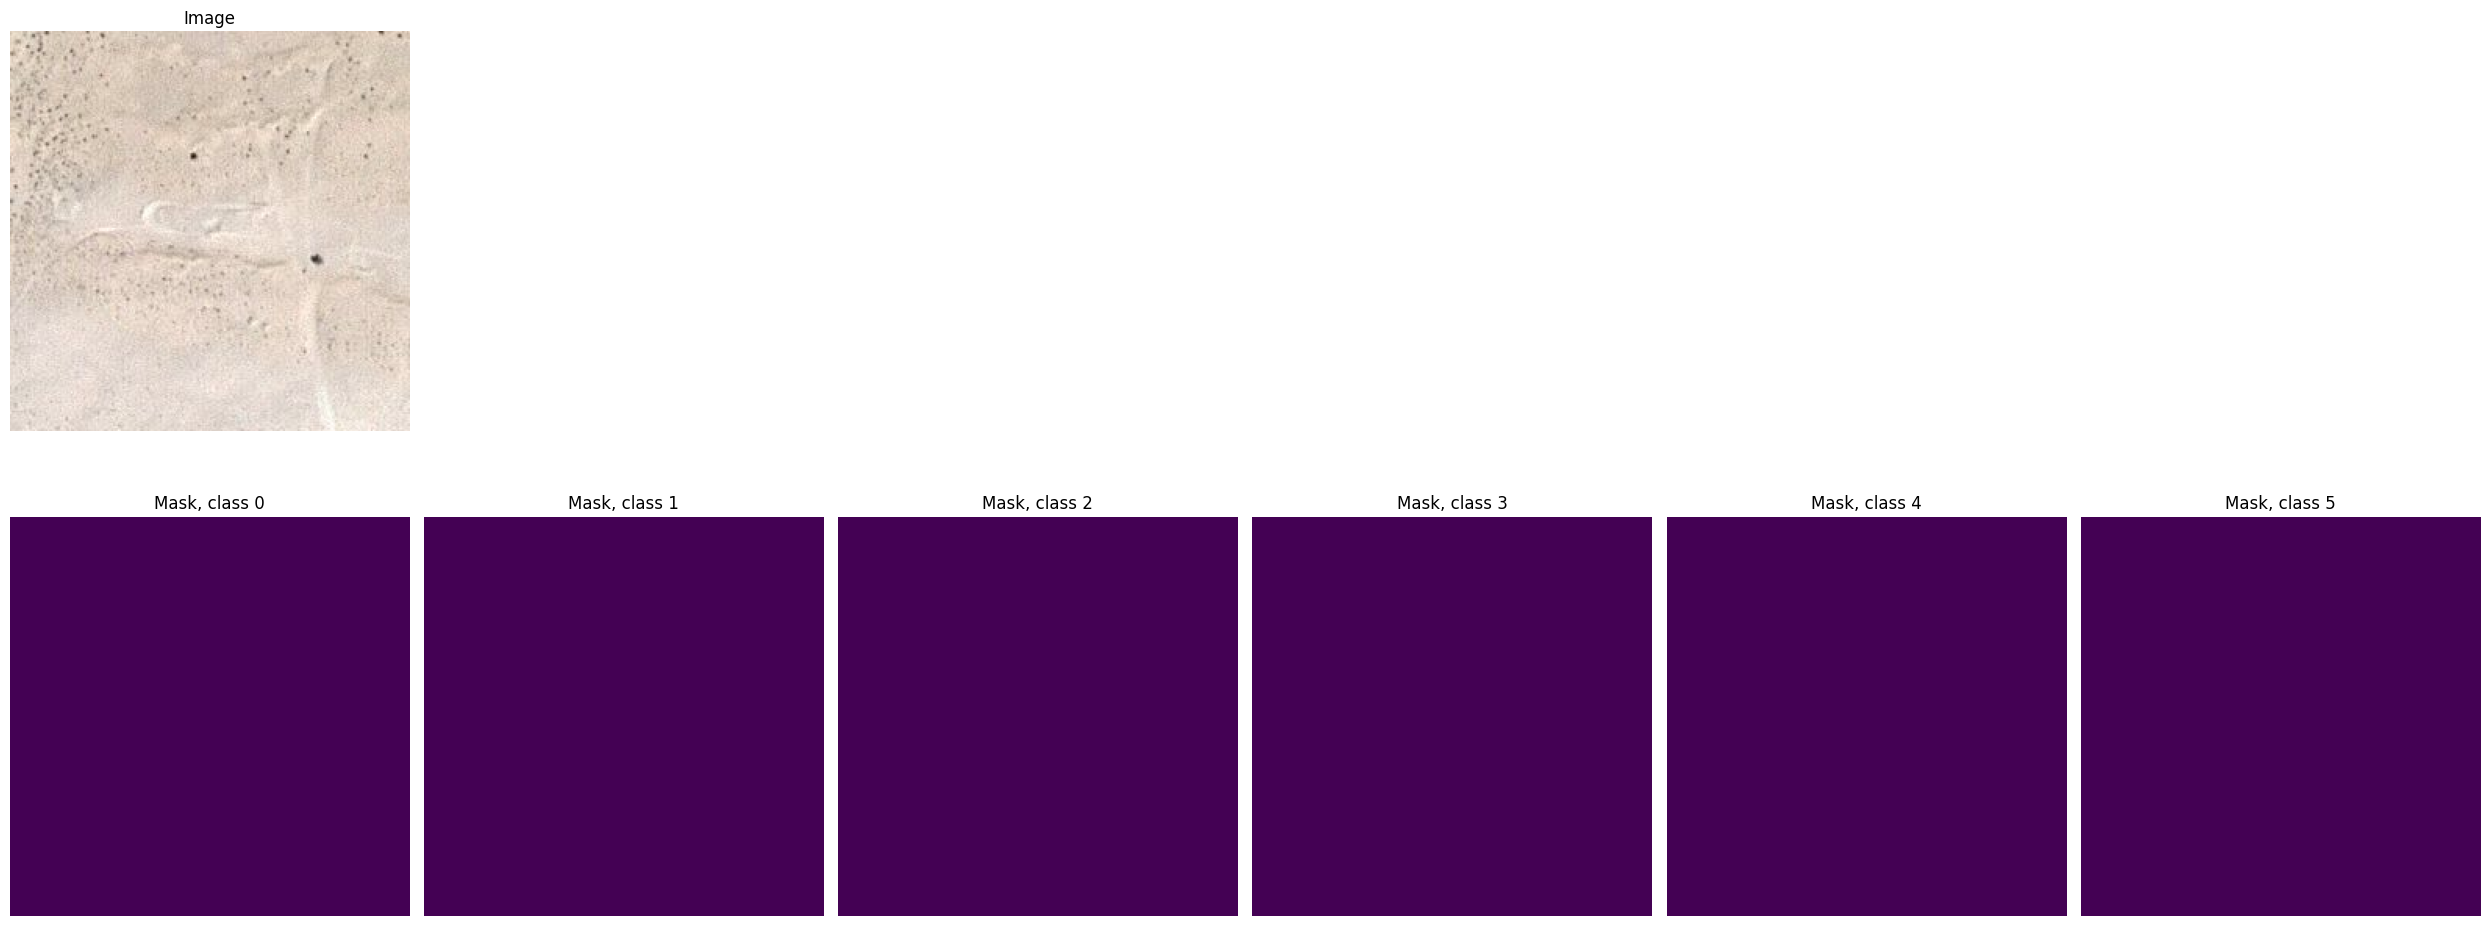

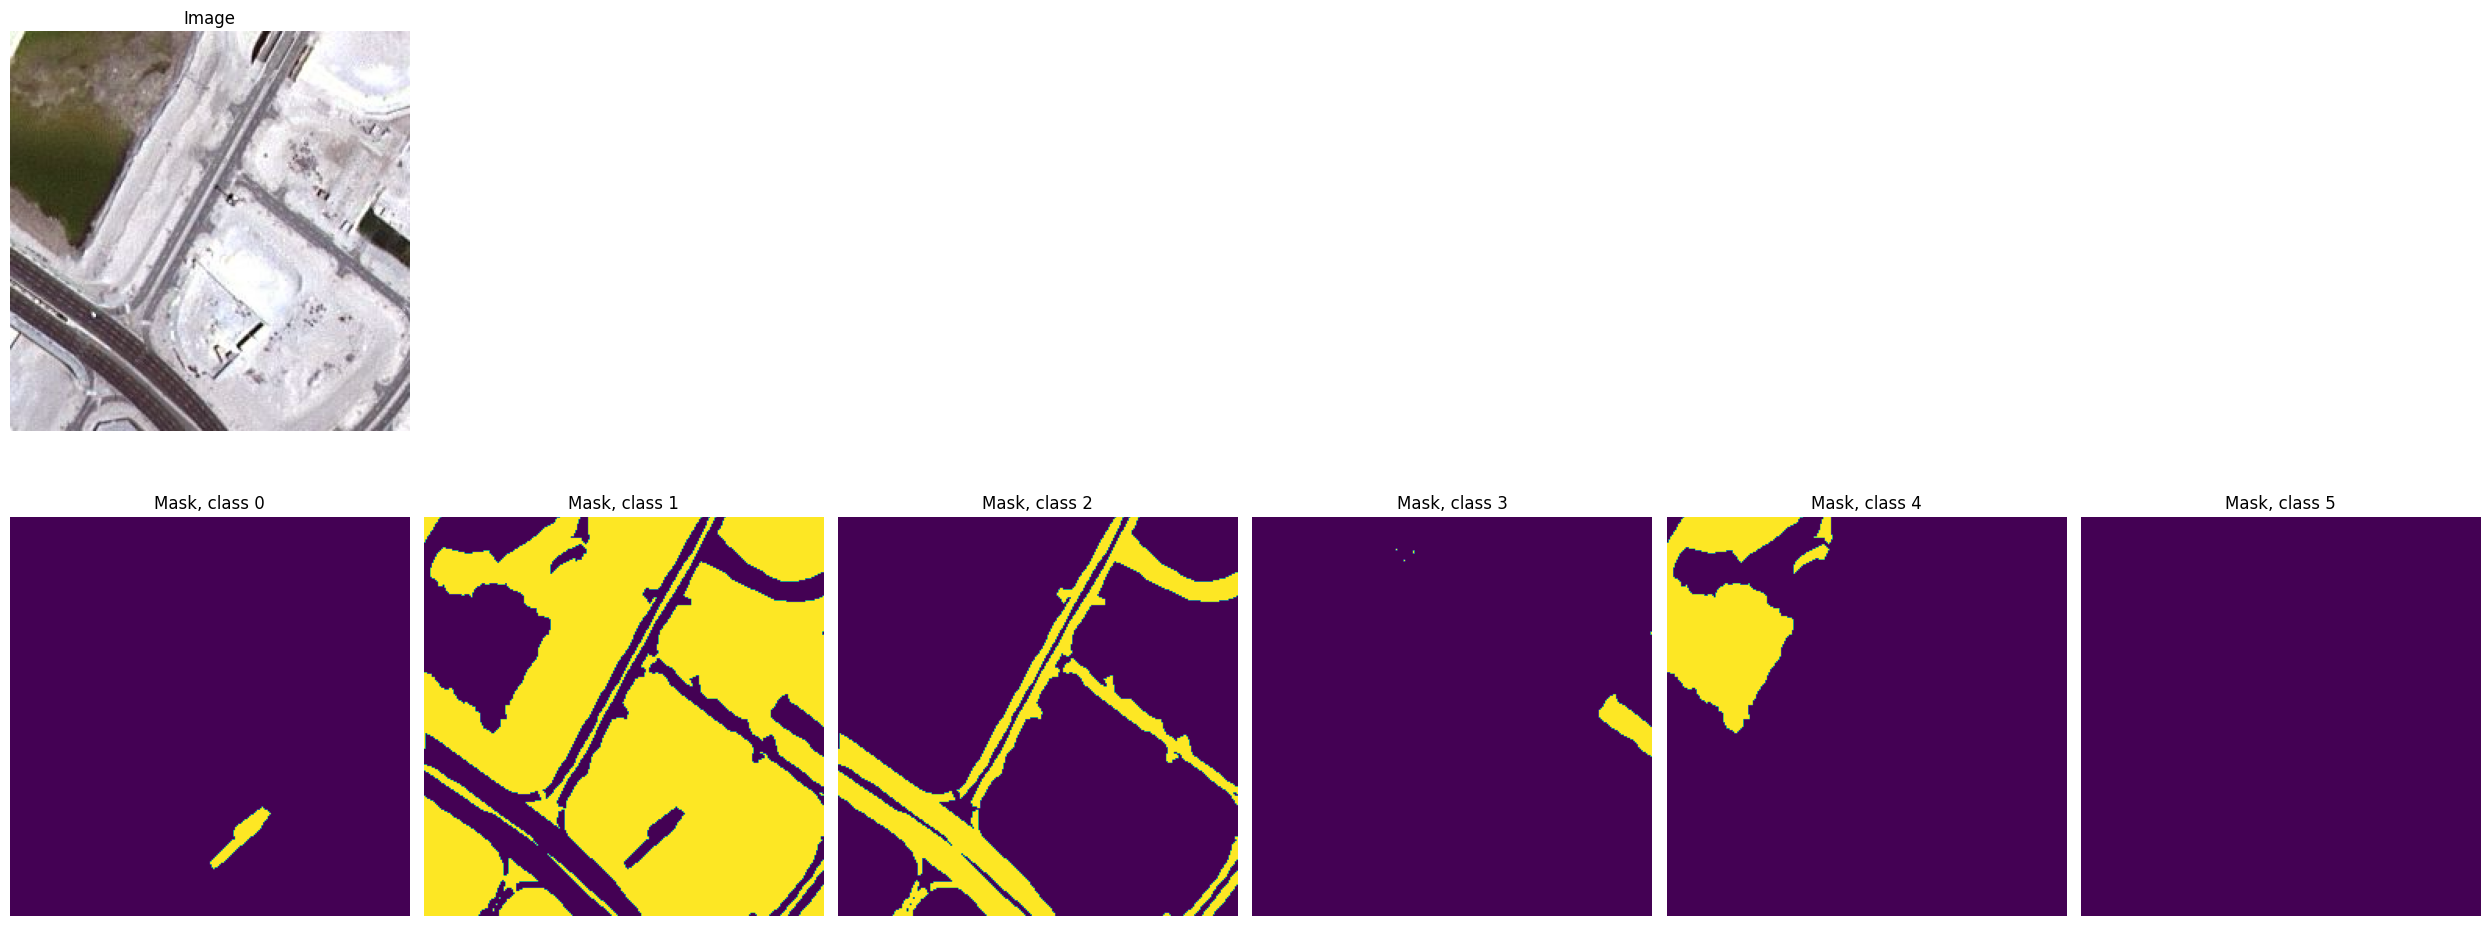

In [ ]:
for i in range(3):
  image, mask = X_test[i], y_test[i]
  plot_example(image, mask)

## 5. MODEL CONFIGURATION

Now it's finally time to dive into the actual construction of our initial, basic architecture. Taking after a U-Net network, my model employs an encoder-decoder architecture, implementing skip-connections to help in the forward and backbard passes.

In [ ]:
def build_model(inputs, outputs, n_classes):
    filters = [16, 32, 64, 128]

    # Encoder
    c1 = Conv2D(filters[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(filters[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(filters[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(filters[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(filters[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(filters[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(filters[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(filters[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(filters[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(filters[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(filters[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(filters[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(filters[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(filters[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Output layer
    outputs = outputs(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


The **encoder**, or contracting path, is made up of multiple **convolutional layers**, to help reduce the number of parameters to learn and increase the receptive field, each deploying a standard **3x3 kernel** and using **'same'** as padding to keep the same size for input images and output feature maps. To add non-linearity to the model and aid learning more complex structures, we use **ReLu** as activation function, which goes hand in hand with **He** initializer. The encoder uses **max pooling** as down-sampling technique, which retains the most promiment features while halving the spatial dimensions thanks to a 2x2 kernel.

On the other hand, the **decoder**, or expansive path, joins together convolutional layers with **transpose convolutions**, used as up-sampling strategy to perform feature mixing and doubling the spatial dimensions, up to the original image size. **Concatenate** layers are used to implement skip-connections.

The two paths are connected through a bottleneck, which also employs two convolutional layers.

In [ ]:
model = build_model(input_layer, output_layer, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 64)     │         32,832 │ conv2d_8[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 128)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 64)     │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 32)   │          8,224 │ conv2d_10[0][0]        │
│ (Conv2DTranspose)    

 Total params: 482,118 (1.84 MB)

 Trainable params: 482,118 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Thanks to the `visualkeras` library, we can visualize our model architecture better.

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


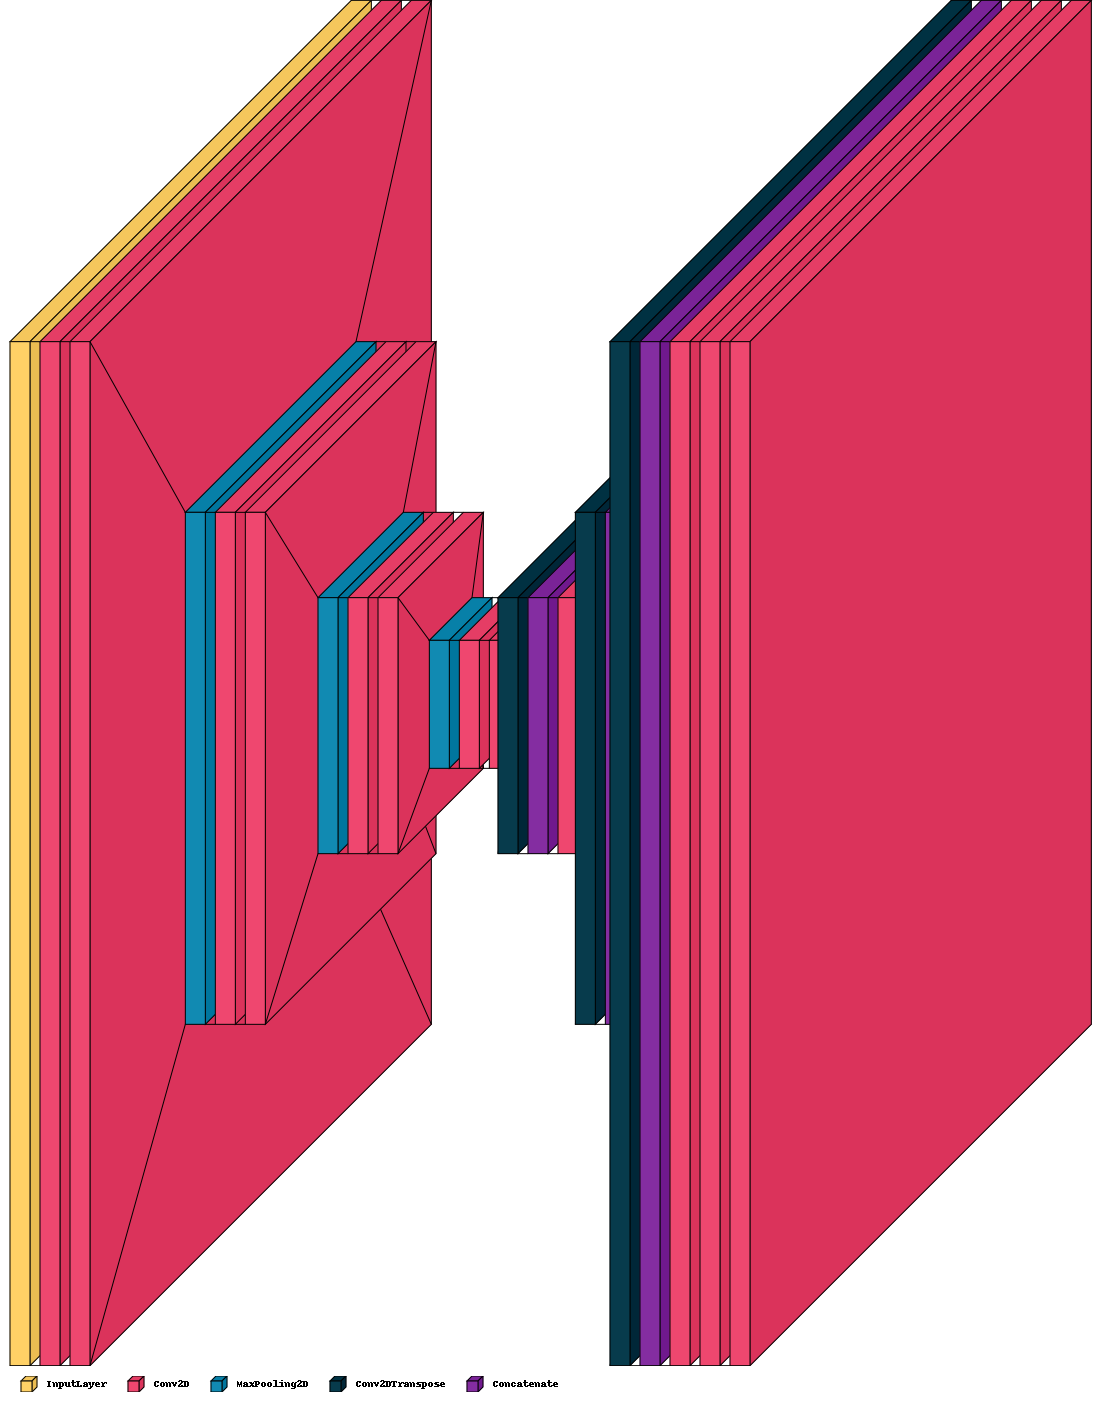

In [ ]:
visualkeras.layered_view(model, legend=True)

## 6. MODEL EVALUATION

Let's evaluate our first model. I will start out with a learning rate of 0.001 and I will train for 5 epochs. Considering the fact that class imbalance is probably likely given the task, I am going to take into account some metrics other than accuracy, namely F1 score, F1 micro and F1 macro.

In [ ]:
initial_lr = 0.001
epochs = 1

model.compile(
    optimizer=Adam(learning_rate=initial_lr),
    loss=loss_function,
    metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 298s 10s/step - accuracy: 0.2510 - loss: 1.6930 - val_accuracy: 0.5384 - val_loss: 1.1648


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5269 - loss: 1.2186
Test Accuracy: 0.5170707702636719


The `np.argmax` function is used to convert the model's raw predictions into class labels. After this operation, `y_pred` will have the shape (number_of_samples, 256, 256) where each value is an integer representing the predicted class for each pixel.

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


To employ the f1_score metrics, it is essential to flatten our `y_test` and `y_pred` first, as scikit-learn's f1_score function expects 1D arrays of true labels and predicted labels. `flatten()` converts the 3D array of shape (number_of_samples, 256, 256) into a 1D array where all the pixel values are listed in a single sequence.

In [ ]:
y_test_flat = np.squeeze(y_test, axis=-1).flatten()
y_pred_flat = y_pred.flatten()

In [ ]:
print(y_test_flat)
print(y_pred_flat)

[1 1 1 ... 1 1 1]
[2 1 1 ... 1 0 0]


In [ ]:
f1_standard = f1_score(y_test_flat, y_pred_flat, average='weighted')
f1_micro = f1_score(y_test_flat, y_pred_flat, average='micro')
f1_macro = f1_score(y_test_flat, y_pred_flat, average='macro')

In [ ]:
print(f"F1 Score: {f1_standard}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

F1 Score: 0.3593011709211719
F1 Score (Micro): 0.5170707411438454
F1 Score (Macro): 0.1168875374693661


We can now build a simple table to show the difference in performance using various metrics.

In [ ]:
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'F1 Score (Micro)', 'F1 Score (Macro)'],
    'Score': [test_accuracy, f1_standard, f1_micro, f1_macro]
})

In [ ]:
metrics

,Metric,Score
0,Accuracy,0.517071
1,F1 Score,0.359301
2,F1 Score (Micro),0.517071
3,F1 Score (Macro),0.116888


We can clearly see that **macro** score is significantly lower than **F1**.

This is consistent with the fact that the macro average calculates the F1 score for each class independently and then takes the average of these scores, treating all classes equally.

F1, on the other hand, accounts for class imbalance by calculating the F1 score for each class and then taking the weighted average based on the number of true instances for each class.

Now, we can display a few images and compare their ground truth masks with our model predictions, to see how well we performed.

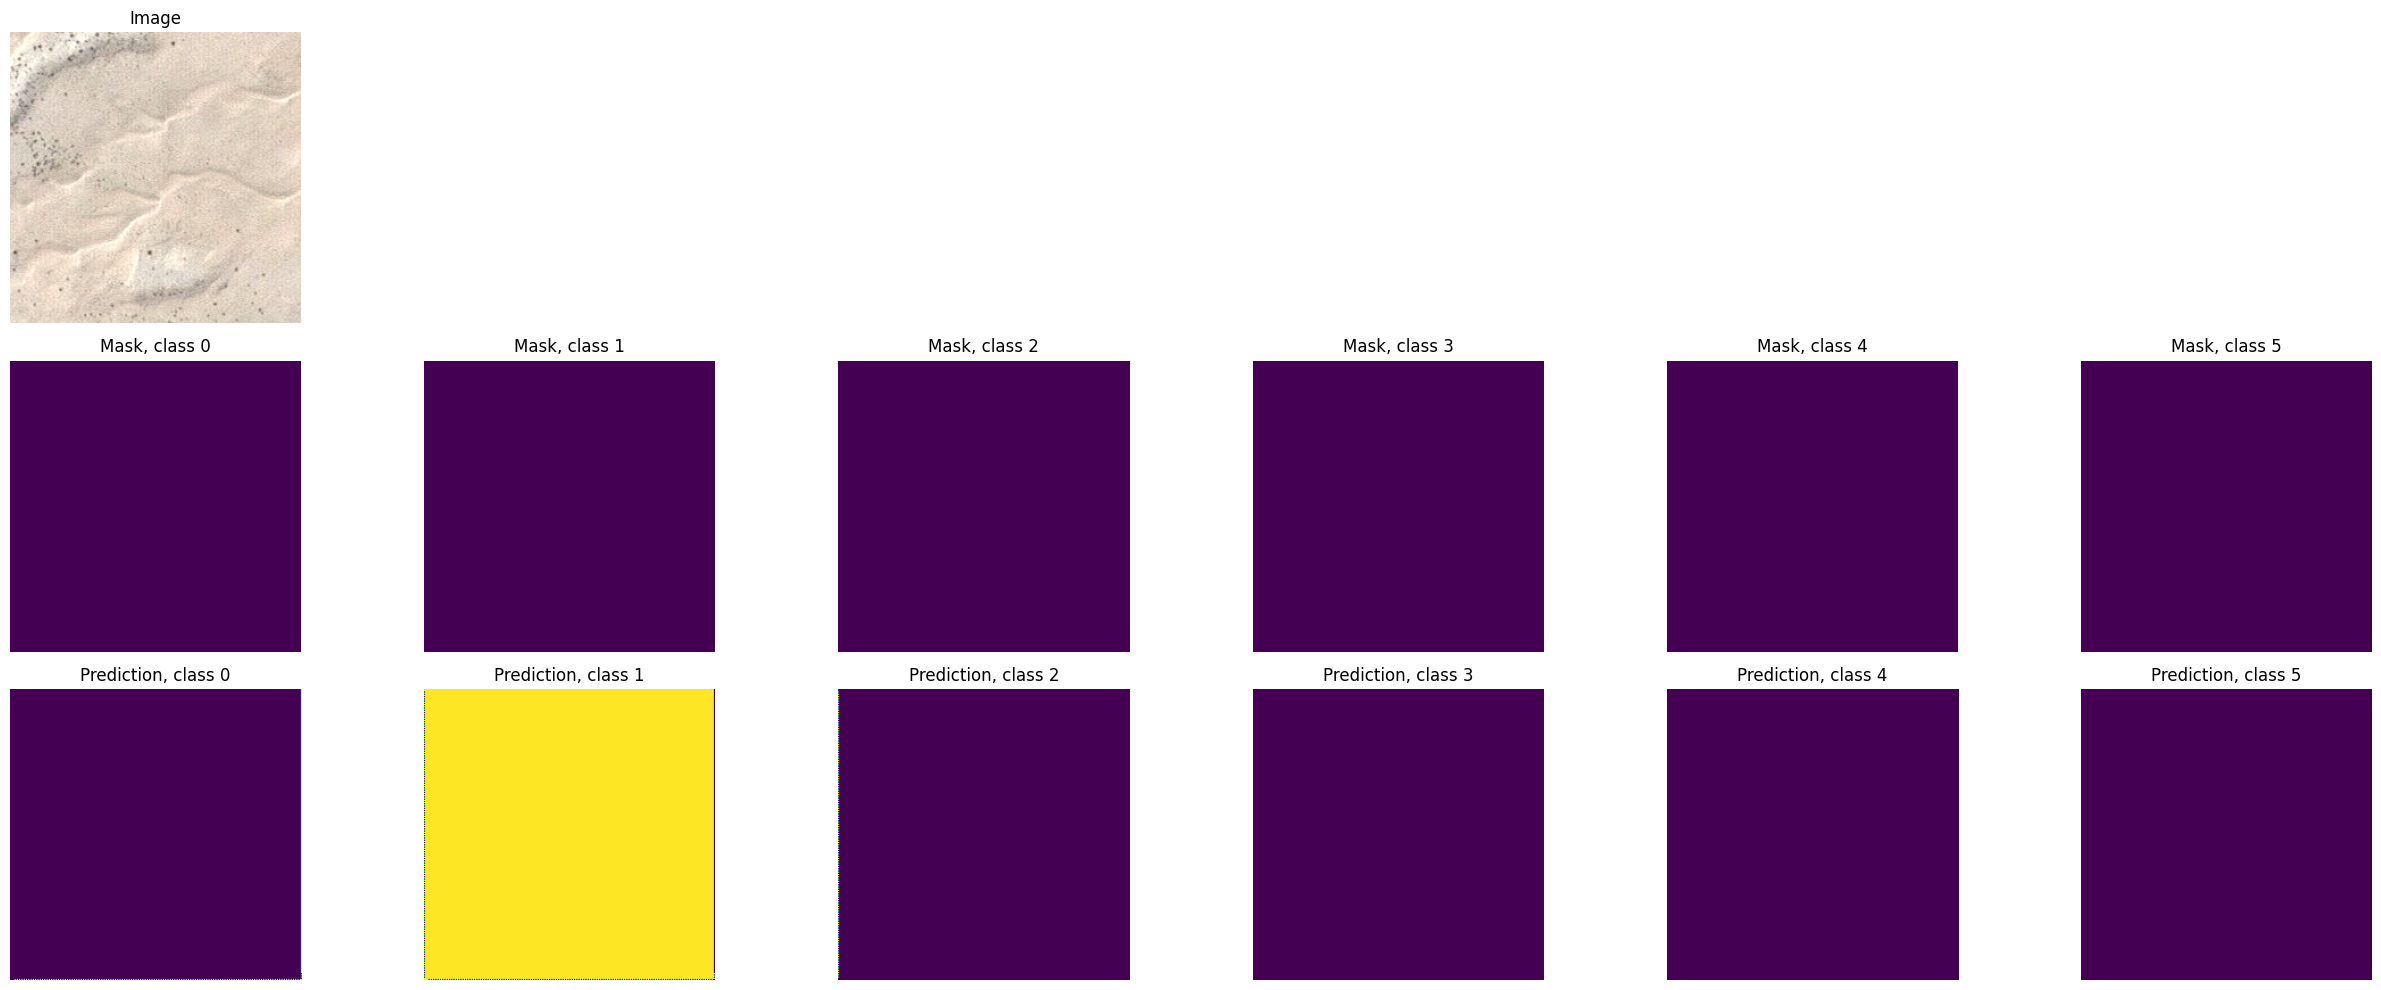

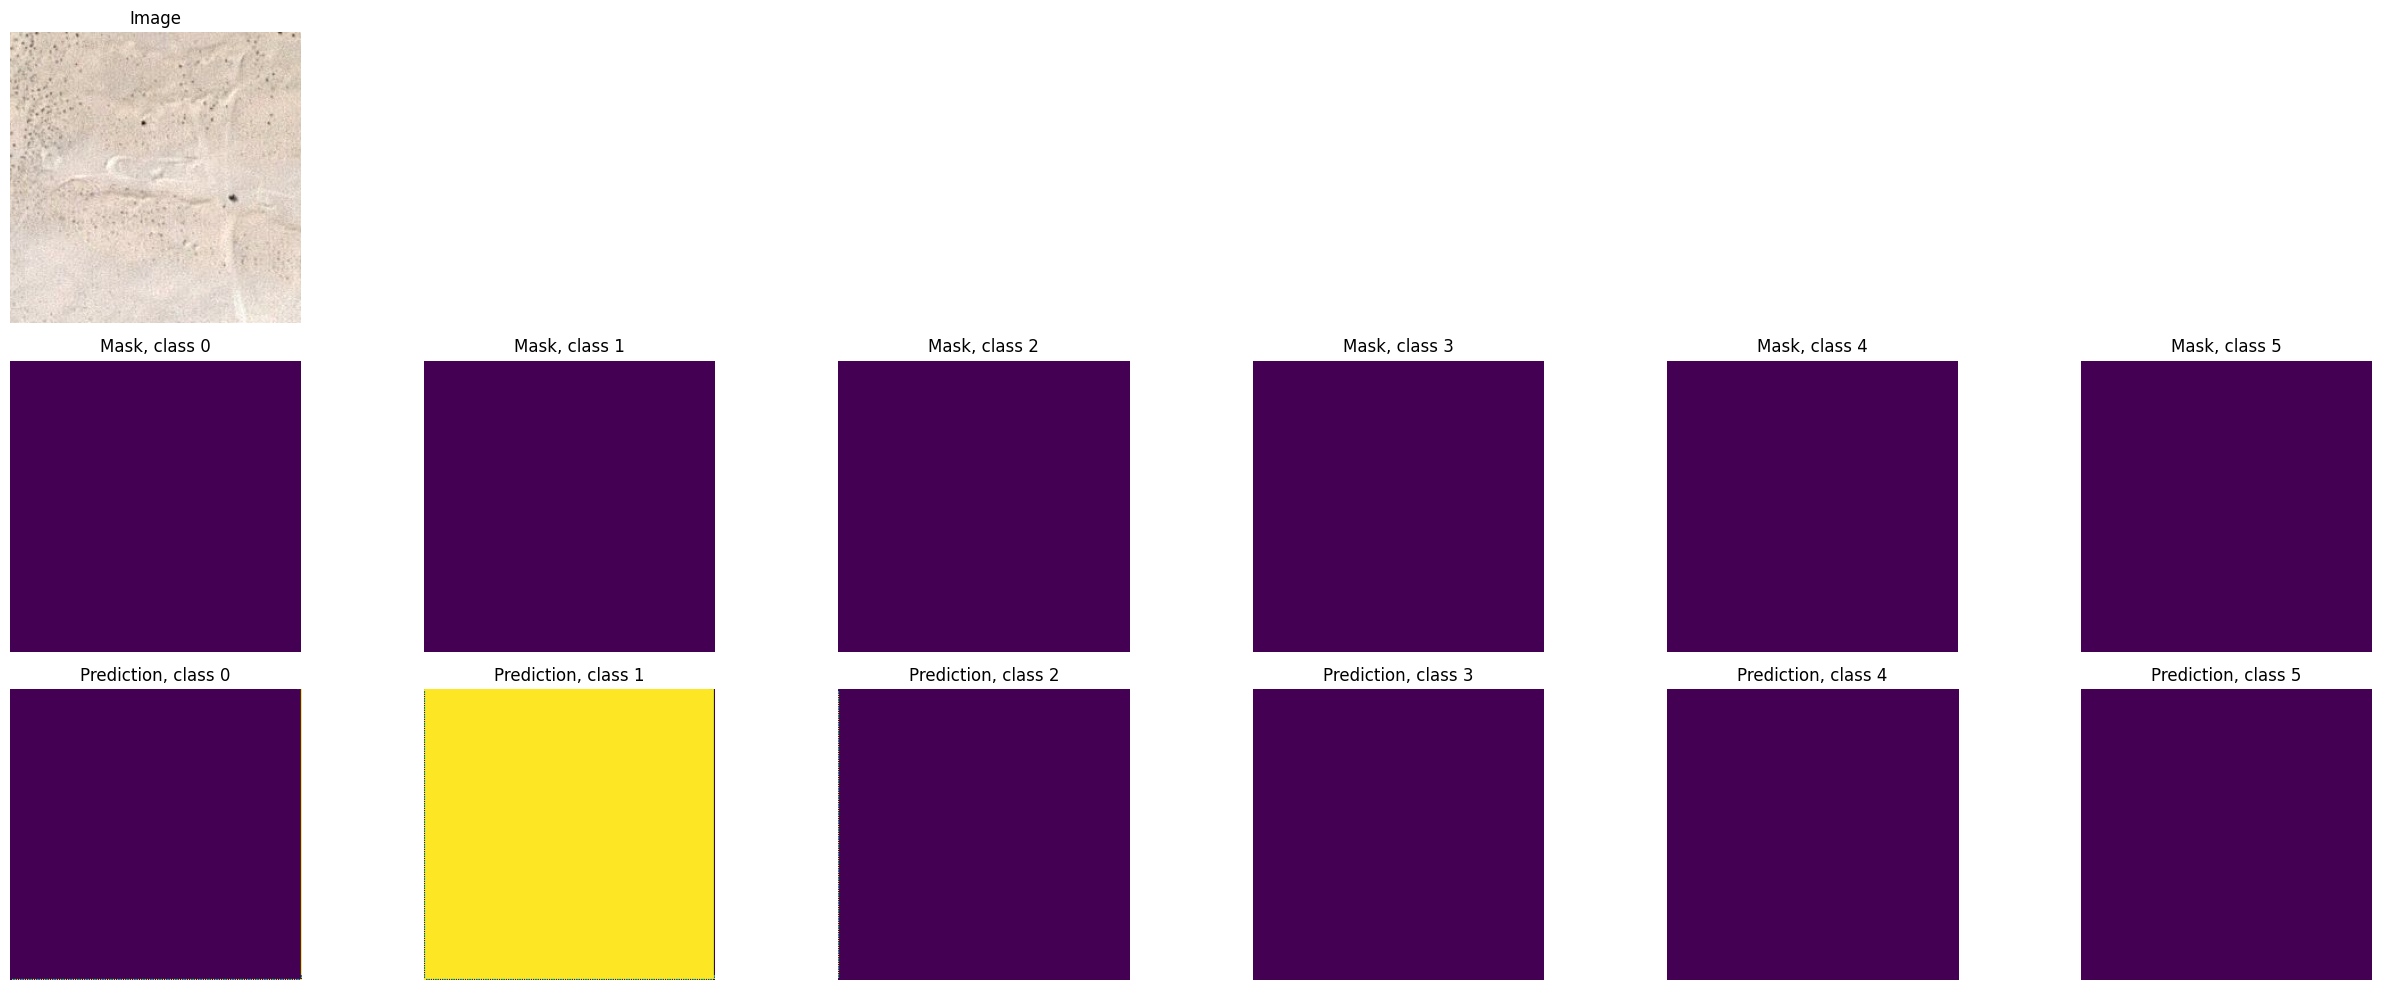

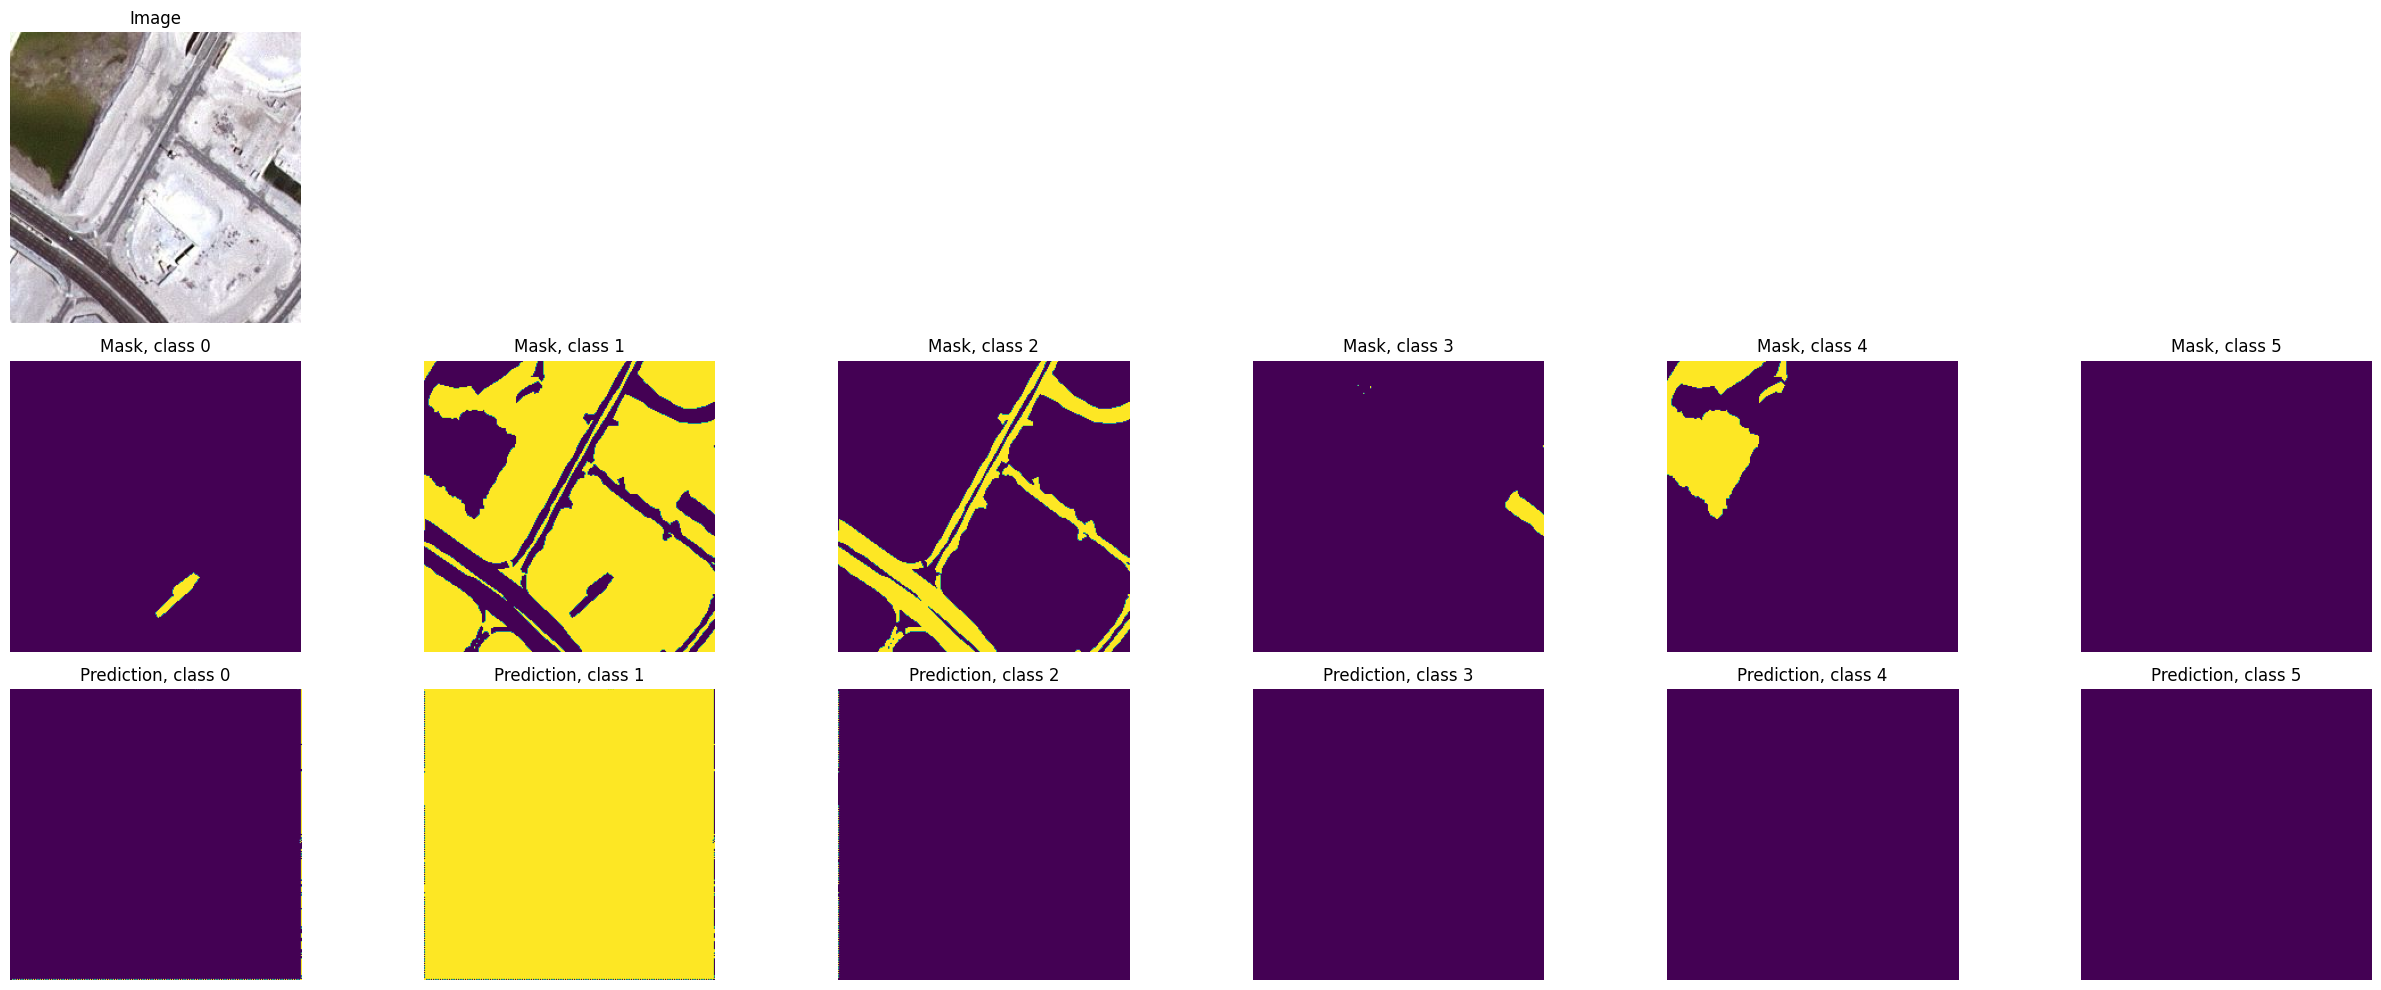

In [ ]:
for i in range(3):
    image = X_test[i]
    mask = y_test[i]
    pred = y_pred[i]

    plot_example(image, mask, pred)

Not bad! But we could still try to improve our model's ability to segment images. To do so, I will perform hyperparameter tuning using cross-validation.

The hyperparameters I want to focus on are the following:
- kernel size
- dropout rate
- learning rate
- optimizer type
- batch size

First things first, since our initial model was very simple and we would like to dinamically implement the hyperparameters, let's define a new, more elaborated structure for our candidate best model.

In [ ]:
def build_best_model(inputs, outputs, n_classes, kernel_size, dropout_rate, learning_rate, optimizer_type):
    filters = [16, 32, 64, 128]

    # Encoder
    c1 = Conv2D(filters[0], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_1')(inputs)
    c1 = Dropout(dropout_rate, name='dropout_1')(c1)
    c1 = Conv2D(filters[0], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_2')(c1)
    p1 = MaxPooling2D((2, 2), name='maxpool2d_1')(c1)

    c2 = Conv2D(filters[1], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_3')(p1)
    c2 = Dropout(dropout_rate, name='dropout_2')(c2)
    c2 = Conv2D(filters[1], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_4')(c2)
    p2 = MaxPooling2D((2, 2), name='maxpool2d_2')(c2)

    c3 = Conv2D(filters[2], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_5')(p2)
    c3 = Dropout(dropout_rate, name='dropout_3')(c3)
    c3 = Conv2D(filters[2], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_6')(c3)
    p3 = MaxPooling2D((2, 2), name='maxpool2d_3')(c3)

    # Bottleneck
    c4 = Conv2D(filters[3], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_7')(p3)
    c4 = Dropout(dropout_rate, name='dropout_4')(c4)
    c4 = Conv2D(filters[3], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_8')(c4)

    # Decoder
    u5 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='same', name='conv2dtranspose_1')(c4)
    u5 = Concatenate(name='concatenate_1')([u5, c3])
    c5 = Conv2D(filters[2], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_9')(u5)
    c5 = Dropout(dropout_rate, name='dropout_5')(c5)
    c5 = Conv2D(filters[2], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_10')(c5)

    u6 = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='same', name='conv2dtranspose_2')(c5)
    u6 = Concatenate(name='concatenate_2')([u6, c2])
    c6 = Conv2D(filters[1], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_11')(u6)
    c6 = Dropout(dropout_rate, name='dropout_6')(c6)
    c6 = Conv2D(filters[1], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_12')(c6)

    u7 = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='same', name='conv2dtranspose_3')(c6)
    u7 = Concatenate(name='concatenate_3')([u7, c1])
    c7 = Conv2D(filters[0], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_13')(u7)
    c7 = Dropout(dropout_rate, name='dropout_7')(c7)
    c7 = Conv2D(filters[0], (kernel_size, kernel_size), activation='relu', padding='same', name='conv2d_14')(c7)

    # Output layer
    outputs = outputs(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_type == 'rmsprop':
      optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    return model


The main difference is that I have added **dropout** layers, which can be a very useful tool for regularization if needed (I still kept 0 as minimum value for the dropout_rate, in case performance is not too compromised by overtraining), and I also integrated different optimizers into the `build_best_model` function.

In [ ]:
def build_model(hp):
    kernel_size = hp.Choice('kernel_size', [3, 5])
    dropout_rate = hp.Float('dropout_rate', min_value=0, max_value=0.4, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    optimizer_type = hp.Choice('optimizer_type', ['adam', 'sgd', 'rmsprop'])
    batch_size = hp.Choice('batch_size', [16, 32, 64])
    model = build_best_model(inputs=input_layer,
                             outputs=output_layer,
                             n_classes=num_classes,
                             kernel_size=kernel_size,
                             dropout_rate=dropout_rate,
                             learning_rate=learning_rate,
                             optimizer_type=optimizer_type)

    if optimizer_type == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_type == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='image_segmentation'
)

In [ ]:
def cross_validate_tuning(X, y, splits=5, epochs=1):
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    val_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
        print(f'Fold {fold}/{splits}')

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Search for the best hyperparameters
        print('Searching for best hyperparameters...')
        tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f'Best Hyperparameters for fold {fold}: {best_hp.values}')

        # Evaluate the best model
        model = tuner.hypermodel.build(best_hp)
        batch_size = best_hp.get('batch_size')
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(val_accuracy)
        print(f'Fold {fold} Validation Accuracy: {val_accuracy}')

    print(f'Mean Validation Accuracy: {np.mean(val_scores)} ± {np.std(val_scores)}')
    return tuner.get_best_hyperparameters(num_trials=1)[0]

I will briefly explain what the above function is doing.

K-Fold cross-validation splits the data into k folds and iterates through each fold, then for each of these folds hyperparameter tuning is performed on the training set and evaluated on the validation set.

The model is therefore trained with the best hyperparameters and the performance is assessed on the validation set.

Finally, validation accuracies are collected, a mean and standard deviation are calculated and printed, and the best found hyperparameters are returned.

Now, let's actually perform cross-validation, using `X_train` as input features and `y_train` as target labels.

In [ ]:
best_hyperparameters = cross_validate_tuning(X_train, y_train, splits=5, epochs=1)

Trial 5 Complete [00h 11m 26s]
val_accuracy: 0.5111836791038513

Best val_accuracy So Far: 0.636309802532196
Total elapsed time: 00h 41m 15s
Best Hyperparameters for fold 1: {'kernel_size': 3, 'dropout_rate': 0.0, 'learning_rate': 0.0024042640990780996, 'optimizer_type': 'rmsprop', 'batch_size': 32}
13/13 ━━━━━━━━━━━━━━━━━━━━ 279s 21s/step - accuracy: 0.4455 - loss: 1.5998 - val_accuracy: 0.5363 - val_loss: 1.1349
Fold 1 Validation Accuracy: 0.5362977385520935
Fold 2/5
Searching for best hyperparameters...
Best Hyperparameters for fold 2: {'kernel_size': 3, 'dropout_rate': 0.0, 'learning_rate': 0.0024042640990780996, 'optimizer_type': 'rmsprop', 'batch_size': 32}
14/14 ━━━━━━━━━━━━━━━━━━━━ 278s 20s/step - accuracy: 0.5396 - loss: 1.4671 - val_accuracy: 0.1989 - val_loss: 1.3981
Fold 2 Validation Accuracy: 0.19891239702701569
Fold 3/5
Searching for best hyperparameters...
Best Hyperparameters for fold 3: {'kernel_size': 3, 'dropout_rate': 0.0, 'learning_rate': 0.0024042640990780996, 'op

We can access the structure of the best model and its hyperparameters.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 16)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool2d_1               │ (None, 128, 128, 16)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ maxpool2d_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool2d_2               │ (None, 64, 64, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ maxpool2d_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool2d_3               │ (None, 32, 32, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ maxpool2d_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2dtranspose_1         │ (None, 64, 64, 64)     │         32,832 │ conv2d_8[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 482,118 (1.84 MB)

 Trainable params: 482,118 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
kernel_size: 3
dropout_rate: 0.0
learning_rate: 0.0024042640990780996
optimizer_type: rmsprop
batch_size: 32


Now calculating the accuracy, F1 score, F1 micro and F1 macro and comparing the results.

In [ ]:
test_loss_best, test_accuracy_best = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_best}")

y_pred_best = np.argmax(best_model.predict(X_test), axis=-1)
y_pred_flat_best = y_pred.flatten()

f1_standard = f1_score(y_test_flat, y_pred_flat_best, average='weighted')
f1_micro = f1_score(y_test_flat, y_pred_flat_best, average='micro')
f1_macro = f1_score(y_test_flat, y_pred_flat_best, average='macro')


5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6367 - loss: 1.1319
Test Accuracy: 0.6232183575630188
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


In [ ]:
metrics_best = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'F1 Score (Micro)', 'F1 Score (Macro)'],
    'Score': [test_accuracy_best, f1_standard, f1_micro, f1_macro]
})

In [ ]:
metrics_best

,Metric,Score
0,Accuracy,0.623218
1,F1 Score,0.359301
2,F1 Score (Micro),0.517071
3,F1 Score (Macro),0.116888


Finally, we can retrain the model with the best hyperparameters on the entire dataset, then get the final performance on the test set.

In [ ]:
retrained_model = tuner.hypermodel.build(best_hyperparameters)
retrained_model.fit(X_train, y_train,
                    batch_size=best_hyperparameters.get('batch_size'),
                    epochs=1,
                    validation_split=0.1,
                    callbacks=[ModelCheckpoint('final_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
                               EarlyStopping(monitor='val_loss', patience=5)])

15/15 ━━━━━━━━━━━━━━━━━━━━ 301s 20s/step - accuracy: 0.1771 - loss: 1.6221 - val_accuracy: 0.5419 - val_loss: 1.1272


In [ ]:
test_loss_final, test_accuracy_final = retrained_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_final}")

y_pred_final = np.argmax(retrained_model.predict(X_test), axis=-1)
y_pred_flat_final = y_pred.flatten()

f1_standard_final = f1_score(y_test_flat, y_pred_flat_final, average='weighted')
f1_micro_final = f1_score(y_test_flat, y_pred_flat_final, average='micro')
f1_macro_final = f1_score(y_test_flat, y_pred_flat_final, average='macro')

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5306 - loss: 1.2063
Test Accuracy: 0.5207618474960327


4/5 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step 

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step


In [ ]:
metrics_final = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'F1 Score (Micro)', 'F1 Score (Macro)'],
    'Score': [test_accuracy_final, f1_standard_final, f1_micro_final, f1_macro_final]
})

In [ ]:
metrics_final

,Metric,Score
0,Accuracy,0.520762
1,F1 Score,0.359301
2,F1 Score (Micro),0.517071
3,F1 Score (Macro),0.116888


Once again, we see that **F1 score** and **F1 micro** return higher results than accuracy and F1 macro. We can conclude than the particular nature of the task implies a rather high likelihood of dealing with imbalanced classes, as certain segments are more spatially represented than others. Accuracy and F1 macro, which do not address **class imbalance** by weighting, cannot tackle the issue and therefore result in slightly worse scores.

And again, we can visualize the best model architecture in a straigthforward manner using `visualkeras`.

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


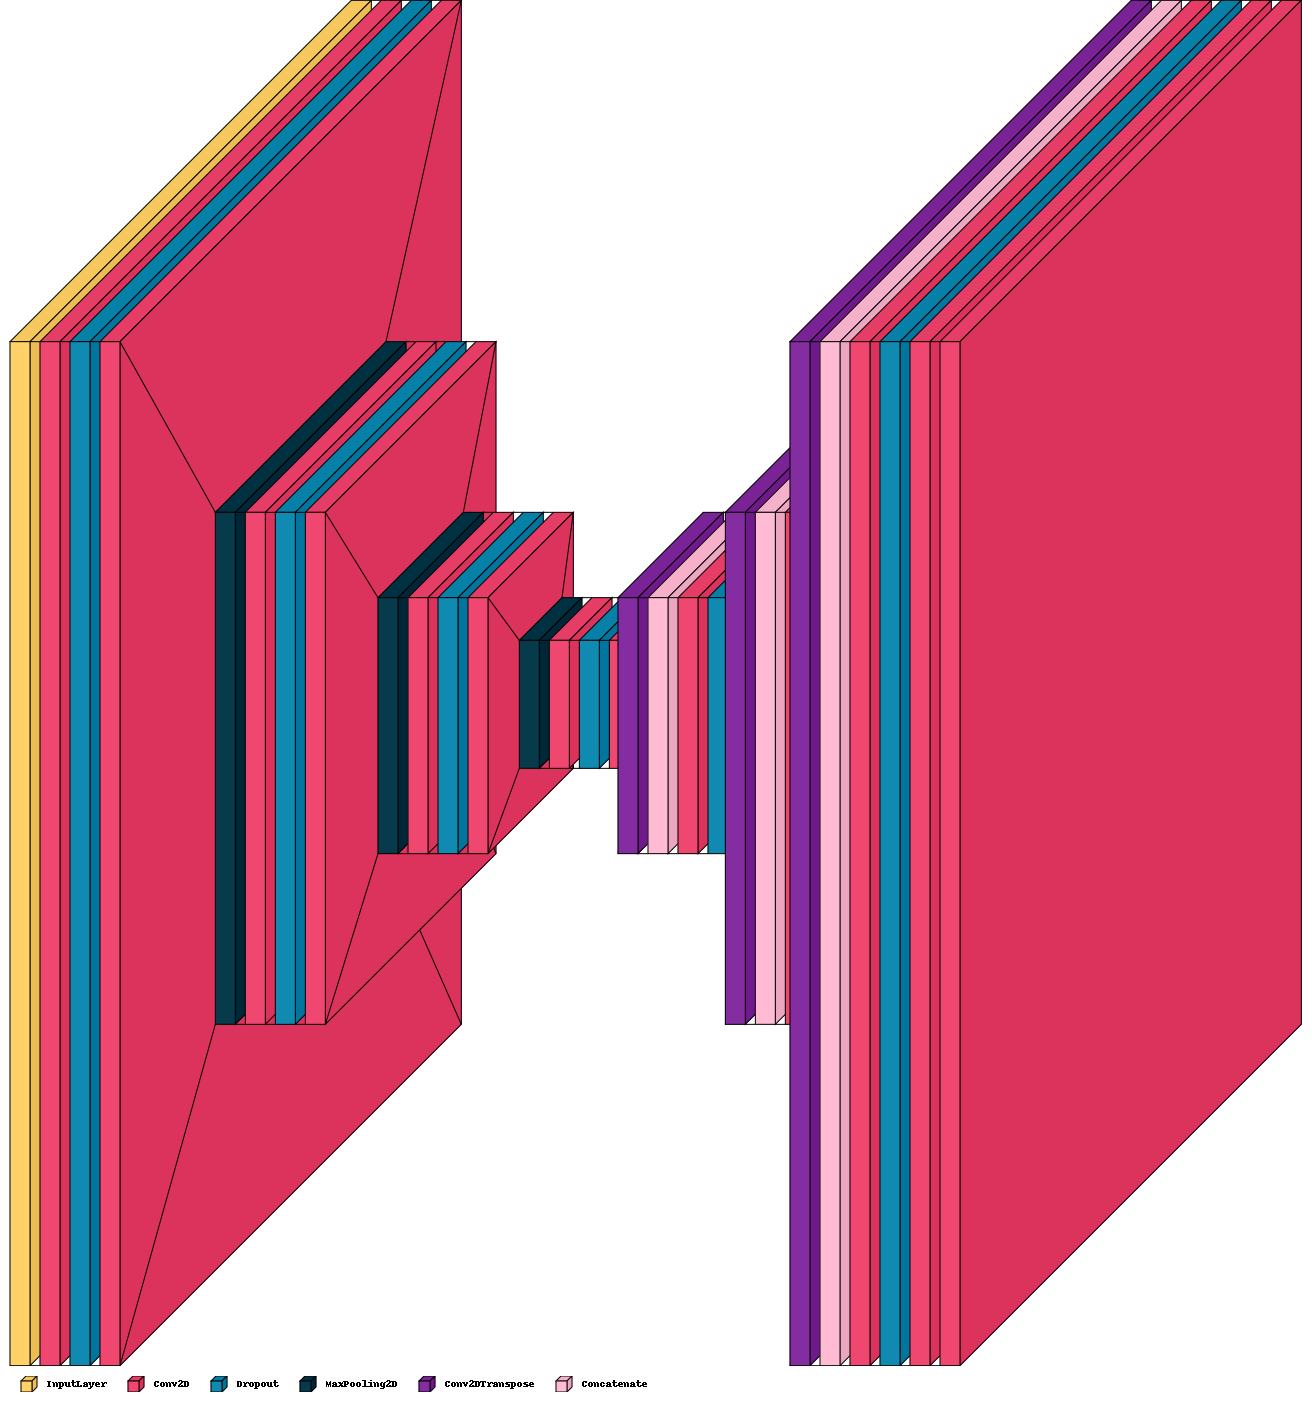

In [ ]:
visualkeras.layered_view(retrained_model, legend=True)

By plotting the **confusion matrix** we can compare the performance across classes. We clearly see that our model works best at classifying class 1, which is also much more represented than the other classes. This confirms our suspicions on class imbalance.

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step


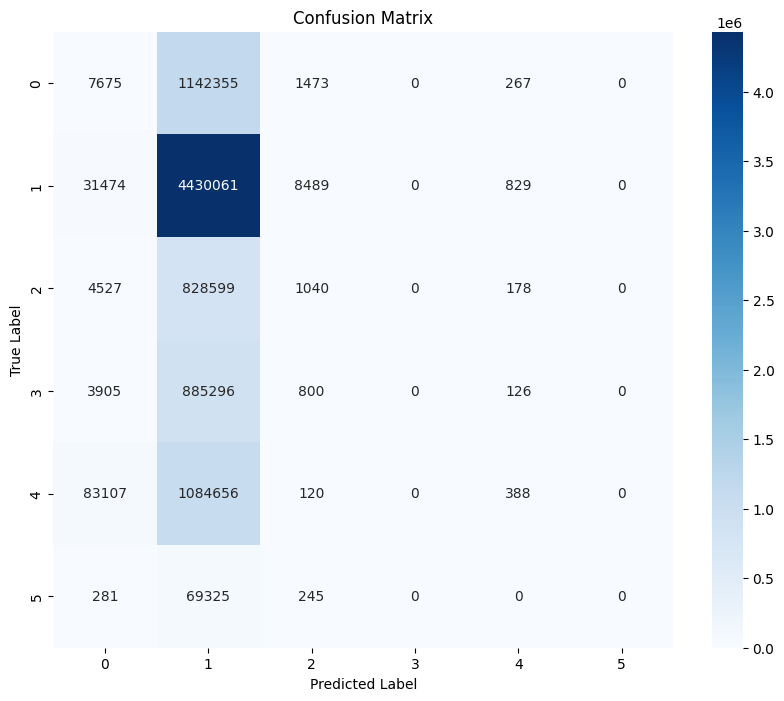

In [ ]:
y_pred_final = np.argmax(retrained_model.predict(X_test), axis=-1)
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat_best)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Using the `plot_example` function we can plot a few examples of comparisons between ground truth masks and predicted ones for the best retrained model.

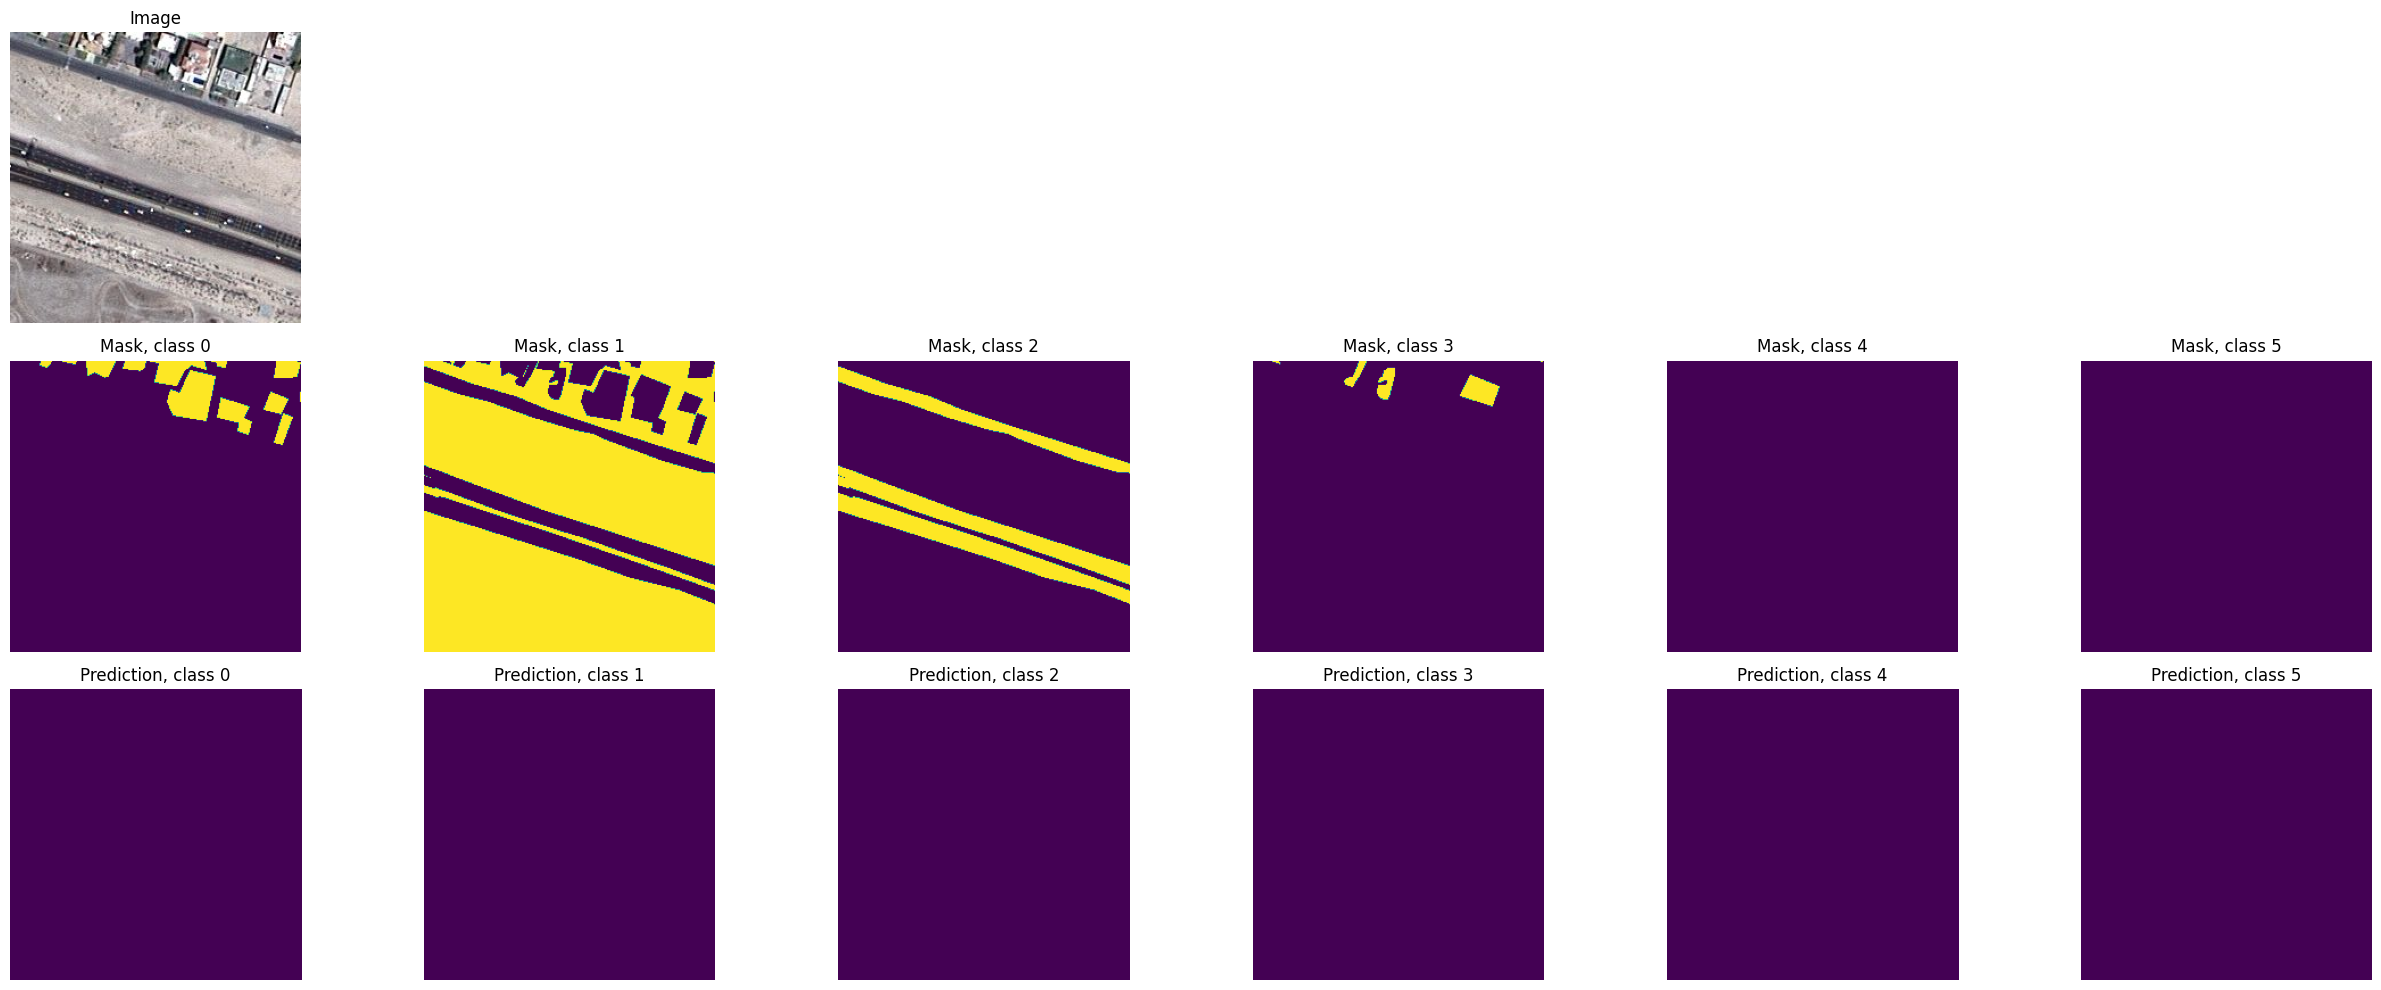

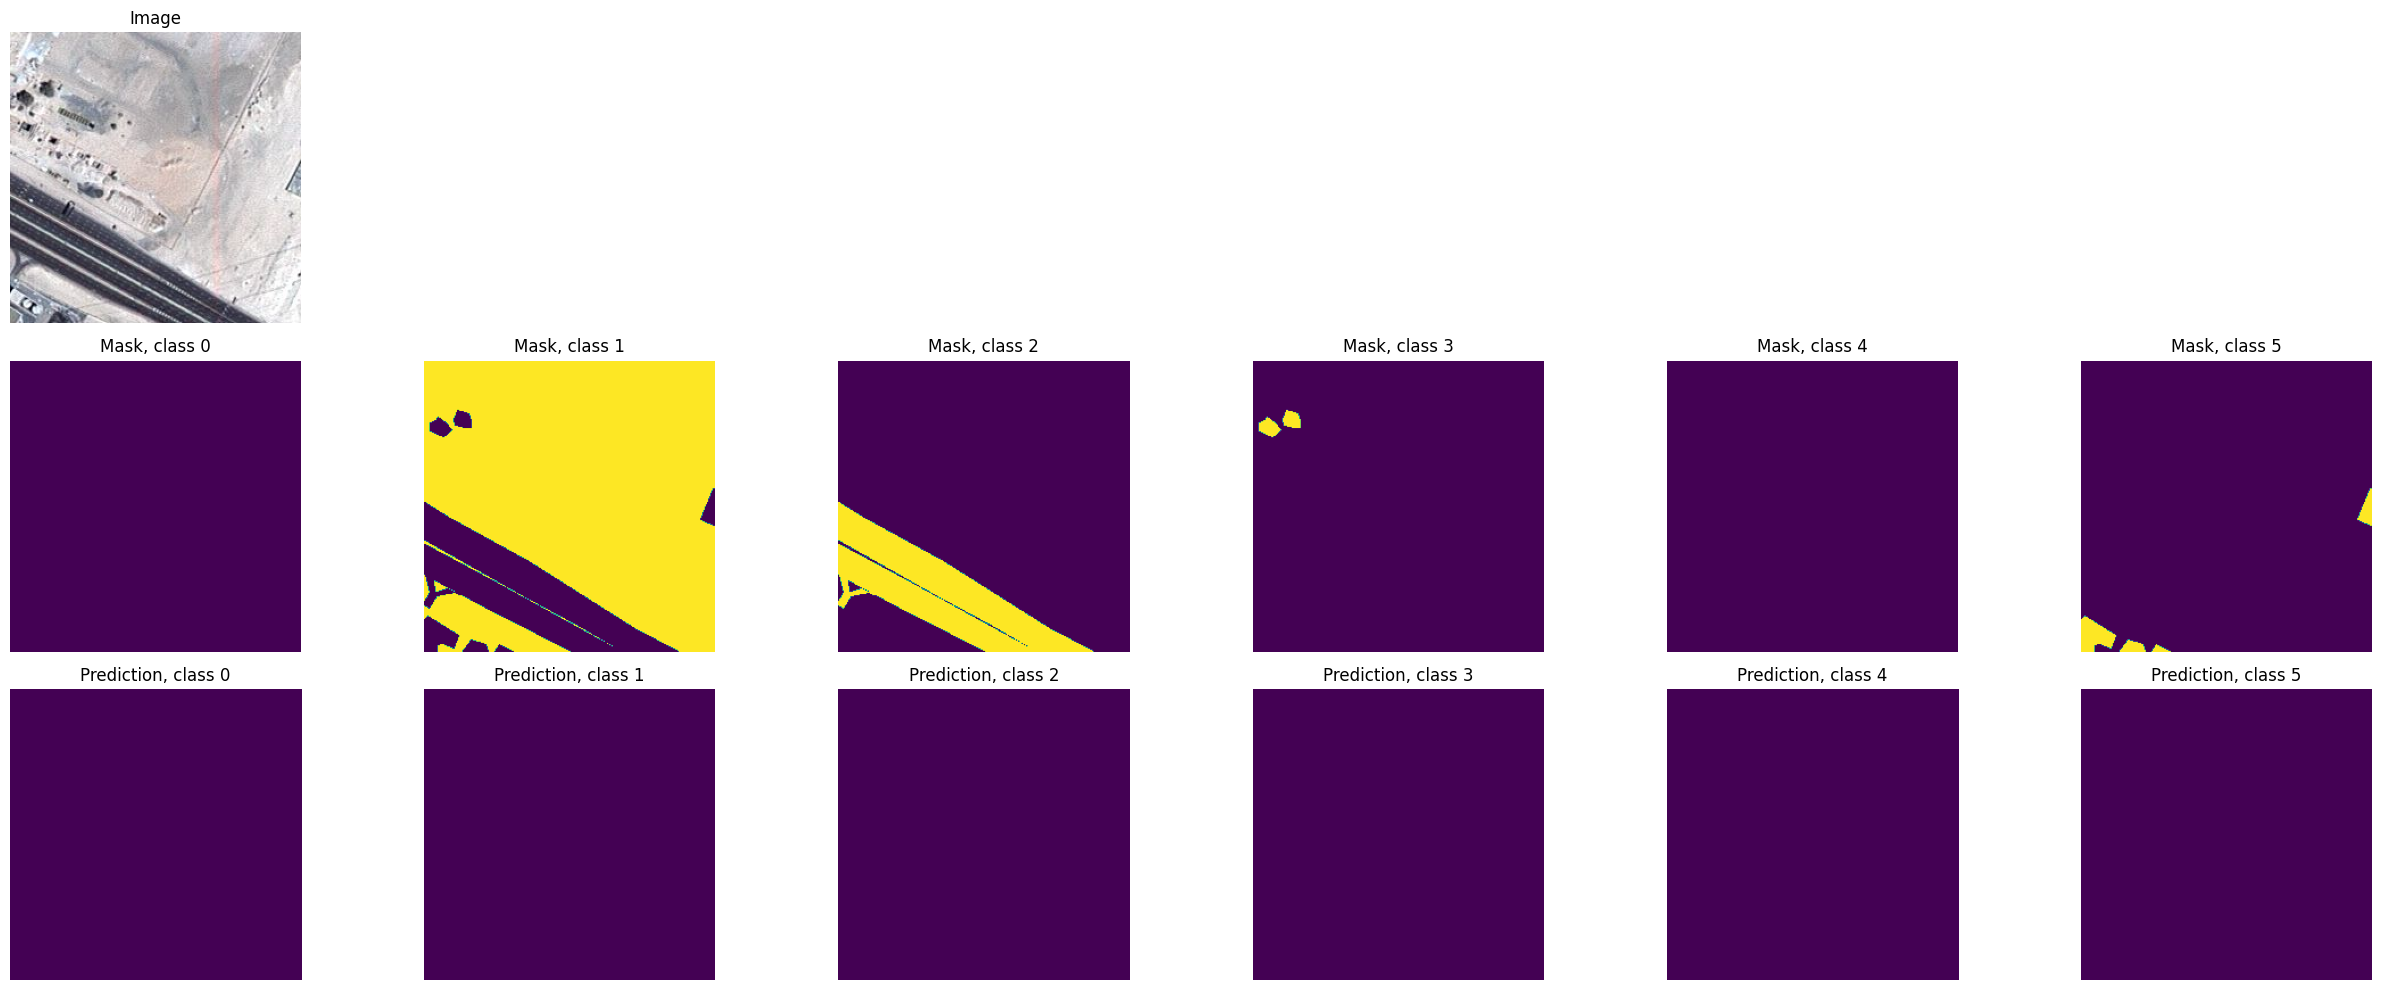

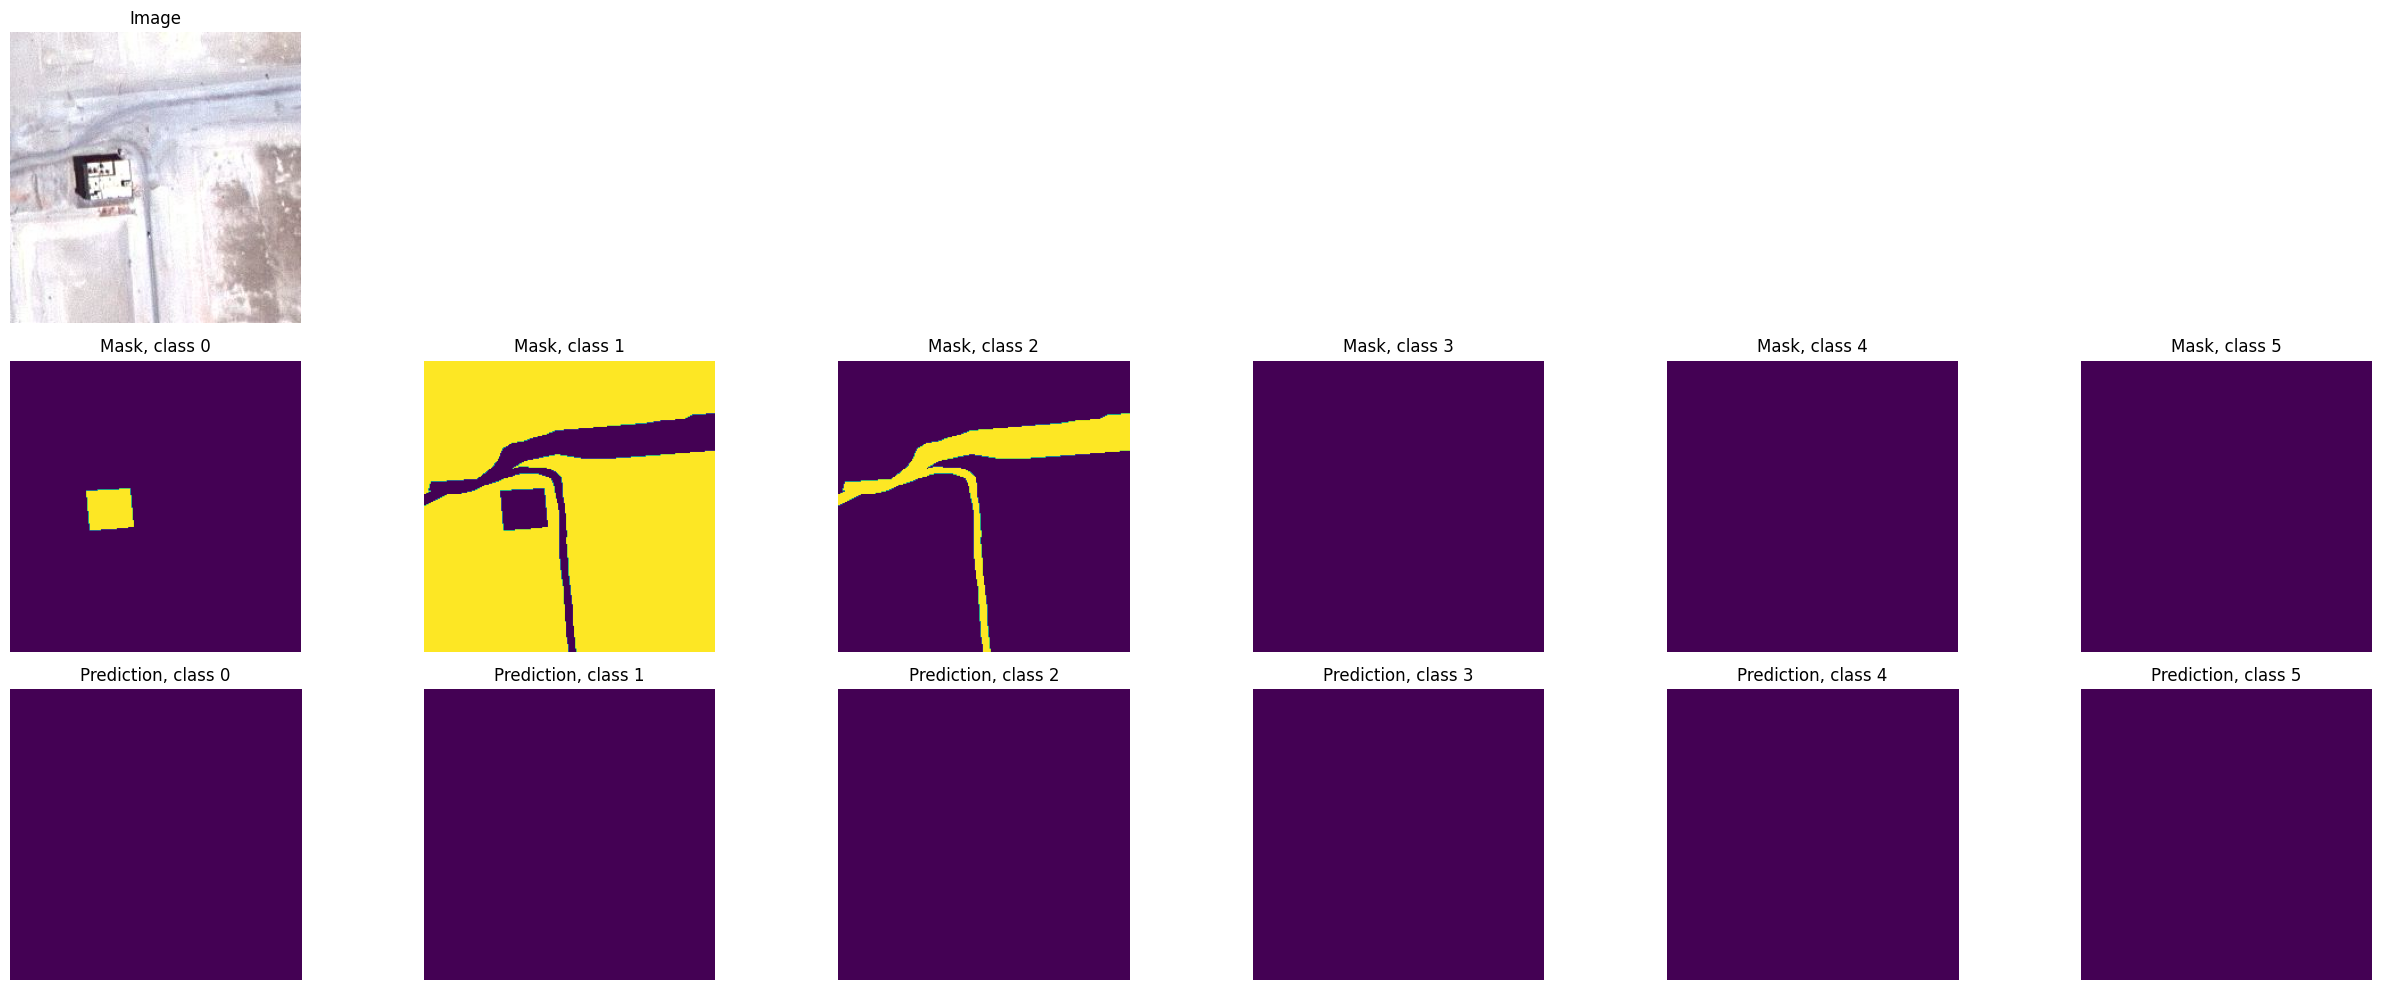

In [ ]:
for i in range(21, 24):
    image = X_test[i]
    mask = y_test[i]
    pred = y_pred_final[i]

    plot_example(image, mask, pred)

## Conclusions

The project shows that an encoder-decoder U-Net based architecture works best with image segmentation.

Due to computational complexity and limitations with Colab runtime, I had to make some quite restricting choices that impacted on the model performance.

However, with enough resources available, some improvements could be made. Examples are keeping the original dataset size to have more material for training, building a deeper network using a higher number of filters, to capture more complex patterns in the images, obtaining a richer and more diverse set of features and learning hierarchical features, and using more epochs for training.

With these precautions, it is guaranteed that the model will be even more high-performance.